The model trained only on DFT features looks pretty good. Let's run permutation importance on the DFT features and make a plot for it

In [3]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed, dump, load
import seaborn as sns
import sklearn
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor


from actlearn import utils

plt.rcParams.update({"font.size":14})

In [8]:
df_exp = pd.read_csv("../data/experimental_results_final.csv", index_col=0)
domain = pd.read_csv("../data/brbr_reaction_domain_batch5.csv")

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
df_exp.dropna(subset=["CAD Yield (%)"], inplace=True)
df_exp.shape

(1291, 2148)

In [10]:
df_exp["selection"].value_counts()

active_learning_2           96
random_1                    95
random_3                    93
test_2                      91
random_4                    90
unexplored                  90
high_yield                  87
active_learning_3           86
random_2                    84
initial_diverse             83
active_learning_1           76
test_1                      70
cores2_test_1               45
cores2_active_learning_1    45
cores2_active_learning_2    44
cores2_test_2               40
test_3                      32
cross_active_learning       30
cross_random                14
Name: selection, dtype: int64

In [11]:
# these batches were run after exploring feature selection
df_exp = df_exp[~df_exp["selection"].isin(["unexplored", "high_yield"])]
df_exp.shape

(1114, 2148)

In [6]:
# add features to domain
domain_dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(utils.rxn_dfp)(rsmi) for rsmi in domain['rsmi']
))
# merging alkyl and aryl DFT features with reaction fingerprints
f_cols = [f'f_{idx}' for idx in range(2048)]
# adding features to domain
domain.loc[:, f_cols] = domain_dfp

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 226 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 4096 tasks      | elapsed:    1.2s
[Parallel(n_jobs=32)]: Done 15296 tasks      | elapsed:    3.1s
[Parallel(n_jobs=32)]: Done 29696 tasks      | elapsed:    5.4s
[Parallel(n_jobs=32)]: Done 33160 tasks      | elapsed:    6.7s
[Parallel(n_jobs=32)]: Done 33312 out of 33312 | elapsed:    6.9s finished


In [7]:
len(domain["smiles_alkyl"].unique())

2776

In [8]:
df_exp["selection"].value_counts()

active_learning_2           96
random_1                    95
random_3                    93
test_2                      91
random_4                    90
active_learning_3           86
random_2                    84
initial_diverse             83
active_learning_1           76
test_1                      70
cores2_test_1               45
cores2_active_learning_1    45
cores2_active_learning_2    44
cores2_test_2               44
test_3                      32
Name: selection, dtype: int64

In [12]:
df_alrand = df_exp[~df_exp["selection"].str.contains("test")]
df_test = df_exp[df_exp["selection"].str.contains("test")]

In [13]:
df_test["selection"].value_counts()

test_2           91
test_1           70
cores2_test_1    45
cores2_test_2    40
test_3           32
Name: selection, dtype: int64

In [14]:
df_test1 = df_test[df_test["selection"].isin(["test_1", "test_2", "test_3"])]
df_test2 = df_test[df_test["selection"].isin(["cores2_test_1", "cores2_test_2"])]
print(len(df_test1["smiles_alkyl"].unique()))
print(len(df_test2["smiles_alkyl"].unique()))

26
23


In [15]:
f_cols = [col for col in df_exp.columns if col.startswith('f_')]
fp_cols = f_cols[:2048]
dft_cols = f_cols[2048:]
target = "CAD Yield (%)"

In [18]:
print(len(dft_cols))
print(len(f_cols))
print(len(fp_cols) + len(dft_cols))

87
2135
2135


In [19]:
rep_feats = []
for i in range(10):
    model = RandomForestRegressor(n_jobs=-1, n_estimators=80, max_depth=6)
    model.fit(df_alrand[dft_cols], df_alrand[target])
    r = permutation_importance(model, df_test[dft_cols], df_test[target], n_repeats=10)
    df_feat = pd.DataFrame.from_dict(r, orient="index").T[["importances_mean", "importances_std"]]
    df_feat.index = dft_cols
    rep_feats.append(df_feat)

In [ ]:
df_catrep = pd.concat(rep_feats)
df_repmean = df_catrep.groupby(df_catrep.index).mean()
df_repmean.sort_values(by="importances_mean", ascending=False, inplace=True)

,importances_mean,importances_std
f_rad_br,0.279760,0.045059
f_tm_freeh_LUMO(eV)_rad,0.128362,0.027859
f_C_tm_water_electrophilic_fasm,0.053598,0.010503
f_core_C_tm_water_charge_loewdin,0.033754,0.008969
f_C_tm_water_electrophilic_paboon,0.025998,0.005413
f_C_tm_water_electrophilic_loewdin,0.022345,0.005837
f_C_tm_water_electrophilic_mulliken,0.016700,0.015970
f_core_Br_tm_water_charge_paboon,0.013399,0.004138
f_core_tm_water_ionization_potential [eV],0.012275,0.004174
f_core_C_tm_water_charge_paboon,0.010908,0.003393


In [33]:
df_repmean.head(8)

,importances_mean,importances_std
f_rad_br,0.279760,0.045059
f_tm_freeh_LUMO(eV)_rad,0.128362,0.027859
f_C_tm_water_electrophilic_fasm,0.053598,0.010503
f_core_C_tm_water_charge_loewdin,0.033754,0.008969
f_C_tm_water_electrophilic_paboon,0.025998,0.005413
f_C_tm_water_electrophilic_loewdin,0.022345,0.005837
f_C_tm_water_electrophilic_mulliken,0.016700,0.015970
f_core_Br_tm_water_charge_paboon,0.013399,0.004138


In [21]:
df_repmean.to_csv("figure_data/feature_permutation_importance.csv", index=False)

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


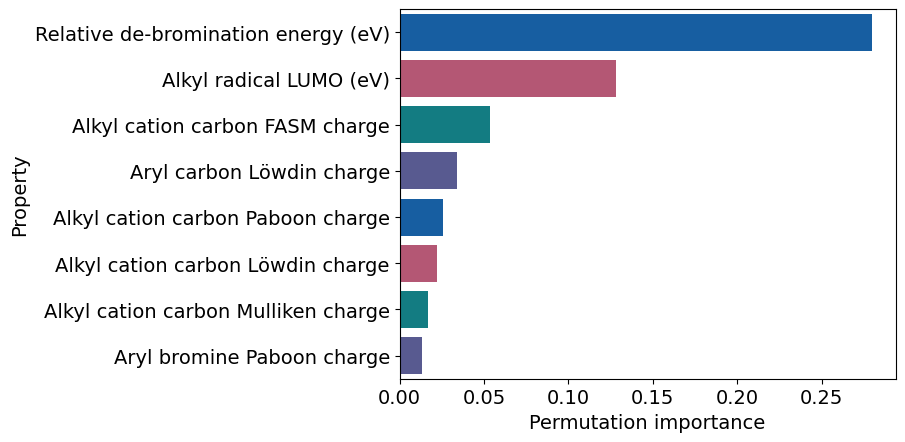

In [41]:
df8 = df_repmean.head(8)
df8["Property"] = ["Relative de-bromination energy (eV)", 
                    "Alkyl radical LUMO (eV)", 
                    "Alkyl cation carbon FASM charge",
                    "Aryl carbon Löwdin charge",
                    "Alkyl cation carbon Paboon charge",
                    "Alkyl cation carbon Löwdin charge",
                    "Alkyl cation carbon Mulliken charge",
                    "Aryl bromine Paboon charge",
                    ]

custom_palette = ['#005EB8', '#C4476E', '#008C95', '#4F5199']
sns.barplot(data=df8, x="importances_mean", y="Property", palette=custom_palette)
plt.xlabel("Permutation importance")
#plt.show()
plt.savefig("images/permutation_importance_all.png", dpi=300, bbox_inches="tight")

In [22]:
def match_charge(col, match_list):
    for m in match_list:
        if m in col:
            return True
    return False

def match_cols(cols, match):
    # remove all columns that match one of the other charge schemes than match
    charge_schemes = ["mulliken", "loewdin", "paboon", "fasm"]
    charge_schemes.remove(match)
    return [c for c in cols if not match_charge(c, charge_schemes)]

#fasm_cols = [c for c in dft_cols if not match_charge(c)]
#paboon_cols = [c for c in dft_cols if not match_charge(c)]
fasm_cols = match_cols(dft_cols, "fasm")
paboon_cols = match_cols(dft_cols, "paboon")
loewdin_cols = match_cols(dft_cols, "loewdin")
mulliken_cols = match_cols(dft_cols, "mulliken")
other_cols = [c for c in dft_cols if not match_charge(c, ["mulliken", "loewdin", "paboon", "fasm"])]
charge_cols = [c for c in dft_cols if match_charge(c, ["mulliken", "loewdin", "paboon", "fasm"])]
print(fasm_cols)

['f_core_tm_water_ionization_potential [eV]', 'f_core_tm_water_electron_affinity [eV]', 'f_core_tm_water_hardness [eV]', 'f_core_tm_water_electronegativity [eV]', 'f_core_tm_water_electrophilicity [eV]', 'f_core_tm_freeh_HOMO(eV)', 'f_core_tm_freeh_LUMO(eV)', 'f_core_tm_freeh_HLgap(eV)', 'f_core_C_tm_water_nmr_iso', 'f_core_C_tm_water_charge_fasm', 'f_core_C_tm_water_nucleophilic_fasm', 'f_core_C_tm_water_electrophilic_fasm', 'f_core_C_tm_water_radical_fasm', 'f_core_Br_tm_water_nmr_iso', 'f_core_Br_tm_water_charge_fasm', 'f_core_Br_tm_water_nucleophilic_fasm', 'f_core_Br_tm_water_electrophilic_fasm', 'f_core_Br_tm_water_radical_fasm', 'f_tm_freeh_HOMO(eV)', 'f_tm_freeh_LUMO(eV)', 'f_tm_freeh_HLgap(eV)', 'f_tm_freeh_HOMO(eV)_alk', 'f_tm_freeh_LUMO(eV)_alk', 'f_tm_freeh_HLgap(eV)_alk', 'f_tm_freeh_HOMO(eV)_rad', 'f_tm_freeh_LUMO(eV)_rad', 'f_tm_freeh_HLgap(eV)_rad', 'f_rad_br', 'f_rad_alk', 'f_C_tm_water_nmr_iso', 'f_C_tm_water_charge_fasm', 'f_C_tm_water_nucleophilic_fasm', 'f_C_tm_wat

In [23]:
def fit_and_score(train, test, target, feature_cols, n_trees=80, depth=6):
    rf_model = sklearn.ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=n_trees, max_depth=depth)
    rf_model.fit(train[feature_cols], train[target])
    y_pred = rf_model.predict(test[feature_cols])
    return utils.score_model(test[target], y_pred)


def replicate_score(train, test, target, feature_cols, repeat=50, n_trees=80, depth=6):
    scores = {}
    for i in range(repeat):
        scores[i] = (fit_and_score(train, test, target, feature_cols, n_trees, depth))
    return pd.DataFrame.from_dict(scores, orient="index").drop(columns="spearmanr").mean()

In [24]:
fasm_score = replicate_score(df_alrand, df_test, target, fasm_cols)

In [25]:
fasm_score1 = replicate_score(df_alrand, df_test1, target, fasm_cols)
fasm_score2 = replicate_score(df_alrand, df_test2, target, fasm_cols)
#paboon_score1 = replicate_score(df_alrand, df_test1, target, paboon_cols)
#paboon_score2 = replicate_score(df_alrand, df_test2, target, paboon_cols)
#loewdin_score1 = replicate_score(df_alrand, df_test1, target, loewdin_cols)
#loewdin_score2 = replicate_score(df_alrand, df_test2, target, loewdin_cols)
#mulliken_score1 = replicate_score(df_alrand, df_test1, target, mulliken_cols)
#mulliken_score2 = replicate_score(df_alrand, df_test2, target, mulliken_cols)

In [17]:
other_score1 = replicate_score(df_alrand, df_test1, target, other_cols)
other_score2 = replicate_score(df_alrand, df_test2, target, other_cols)
charge_score1 = replicate_score(df_alrand, df_test1, target, charge_cols)
charge_score2 = replicate_score(df_alrand, df_test2, target, charge_cols)

In [18]:
# non-opt model with params from active learning
score1_500 = replicate_score(df_alrand, df_test1, target, f_cols, n_trees=500, depth=None)
score2_500 = replicate_score(df_alrand, df_test2, target, f_cols, n_trees=500, depth=None)

In [19]:
score1_80 = replicate_score(df_alrand, df_test1, target, f_cols)
score2_80 = replicate_score(df_alrand, df_test2, target, f_cols)

In [20]:
score1_norad = replicate_score(df_alrand, df_test1, target, f_cols)
score2_noions = replicate_score(df_alrand, df_test2, target, f_cols)

In [21]:
# hyperopt model trained with all features
df_core1 = pd.read_csv("../data/hyperopt_pred_core1.csv")
df_core2 = pd.read_csv("../data/hyperopt_pred_core2.csv")

In [22]:
# for comparison with DFT only scores to subsets with different features
dfd1_cat = pd.read_csv("../data/replicate_model_performance_core1_features.csv")
dfd2_cat = pd.read_csv("../data/replicate_model_performance_core2_features.csv")
scores_dft1 = dfd1_cat[dfd1_cat["features"] == "DFT"].set_index("Dataset").T["AL+Random"]
scores_dft2 = dfd1_cat[dfd1_cat["features"] == "DFT"].set_index("Dataset").T["AL+Random"]

In [23]:
dft_score1 = replicate_score(df_alrand, df_test1, target, dft_cols)
dft_score2 = replicate_score(df_alrand, df_test2, target, dft_cols)

In [24]:
agg_scores1 = pd.DataFrame({"80":score1_80, "500":score1_500})
agg_scores2 = pd.DataFrame({"80":score2_80, "500":score2_500})

agg_f1 = agg_scores1.loc[["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]]
agg_f1["Threshold"] = [10,20,30,40,50]
agg_f2 = agg_scores2.loc[["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]]
agg_f2["Threshold"] = [10,20,30,40,50]

aggstack_f1 = agg_f1.set_index("Threshold").stack().reset_index().rename(columns={"level_1":"agg_type", 0:"f1"})
aggstack_f2 = agg_f2.set_index("Threshold").stack().reset_index().rename(columns={"level_1":"agg_type", 0:"f1"})

In [26]:
fasm_feats = []
for i in range(10):
    model = RandomForestRegressor(n_jobs=-1, n_estimators=80, max_depth=6)
    model.fit(df_alrand[fasm_cols], df_alrand[target])
    r = permutation_importance(model, df_test[fasm_cols], df_test[target], n_repeats=10)
    df_feat = pd.DataFrame.from_dict(r, orient="index").T[["importances_mean", "importances_std"]]
    df_feat.index = fasm_cols
    fasm_feats.append(df_feat)

In [27]:
df_catrep = pd.concat(fasm_feats)
df_fasm = df_catrep.groupby(df_catrep.index).mean()
df_fasm.sort_values(by="importances_mean", ascending=False, inplace=True)
df_fasm.head(10)

,importances_mean,importances_std
f_rad_br,0.322225,0.053371
f_C_tm_water_electrophilic_fasm,0.140506,0.029652
f_tm_freeh_LUMO(eV)_rad,0.117506,0.026675
f_core_tm_water_ionization_potential [eV],0.047478,0.010826
f_Br_tm_water_electrophilic_fasm,0.044059,0.009150
f_core_tm_freeh_HOMO(eV),0.012543,0.004217
f_core_C_tm_water_nucleophilic_fasm,0.012124,0.003499
f_tm_freeh_HLgap(eV)_rad,0.011501,0.004522
f_Br_tm_water_radical_fasm,0.010934,0.004122
f_core_C_tm_water_radical_fasm,0.010012,0.003182


In [28]:
df_fasm.to_csv("figure_data/feature_permutation_importance_fasm.csv")
#df_paboon.to_csv("figure_data/feature_permutation_importance_paboon.csv")

In [ ]:
df_fasm["property"] = fasm_cols

In [29]:
df_fasm = pd.read_csv("figure_data/feature_permutation_importance_fasm.csv", index_col=0)
df_fasm.head(8)

,importances_mean,importances_std
f_rad_br,0.322225,0.053371
f_C_tm_water_electrophilic_fasm,0.140506,0.029652
f_tm_freeh_LUMO(eV)_rad,0.117506,0.026675
f_core_tm_water_ionization_potential [eV],0.047478,0.010826
f_Br_tm_water_electrophilic_fasm,0.044059,0.009150
f_core_tm_freeh_HOMO(eV),0.012543,0.004217
f_core_C_tm_water_nucleophilic_fasm,0.012124,0.003499
f_tm_freeh_HLgap(eV)_rad,0.011501,0.004522


In [31]:
print(df_exp["f_rad_br"].corr(df_exp["f_C_tm_water_electrophilic_fasm"]))
print(df_exp["f_rad_br"].corr(df_exp["f_tm_freeh_LUMO(eV)_rad"]))

0.08756194810170674
0.2850582015548553


In [32]:
df_fasm.index.name = "property"
df_fasm.reset_index(inplace=True)
df_fasm.head(8)

,property,importances_mean,importances_std
0,f_rad_br,0.322225,0.053371
1,f_C_tm_water_electrophilic_fasm,0.140506,0.029652
2,f_tm_freeh_LUMO(eV)_rad,0.117506,0.026675
3,f_core_tm_water_ionization_potential [eV],0.047478,0.010826
4,f_Br_tm_water_electrophilic_fasm,0.044059,0.009150
5,f_core_tm_freeh_HOMO(eV),0.012543,0.004217
6,f_core_C_tm_water_nucleophilic_fasm,0.012124,0.003499
7,f_tm_freeh_HLgap(eV)_rad,0.011501,0.004522


/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


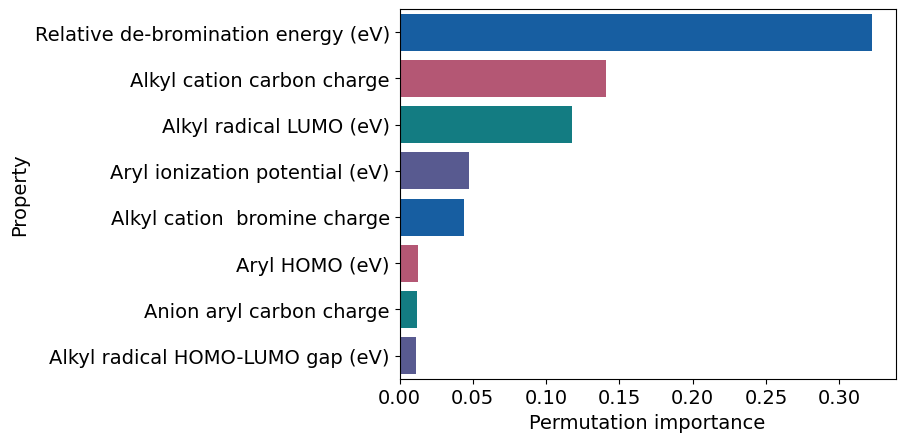

In [38]:
df_fasm8 = df_fasm.head(8)
df_fasm8["Property"] = ["Relative de-bromination energy (eV)", "Alkyl cation carbon charge", "Alkyl radical LUMO (eV)", 
                       "Aryl ionization potential (eV)",
                       "Alkyl cation  bromine charge",
                        "Aryl HOMO (eV)",
                        "Anion aryl carbon charge",
                        "Alkyl radical HOMO-LUMO gap (eV)"
                        ]

custom_palette = ['#005EB8', '#C4476E', '#008C95', '#4F5199']
sns.barplot(data=df_fasm8, x="importances_mean", y="Property", palette=custom_palette)
plt.xlabel("Permutation importance")
#plt.show()
plt.savefig("images/permutation_importance_fasm.png", dpi=300, bbox_inches="tight")

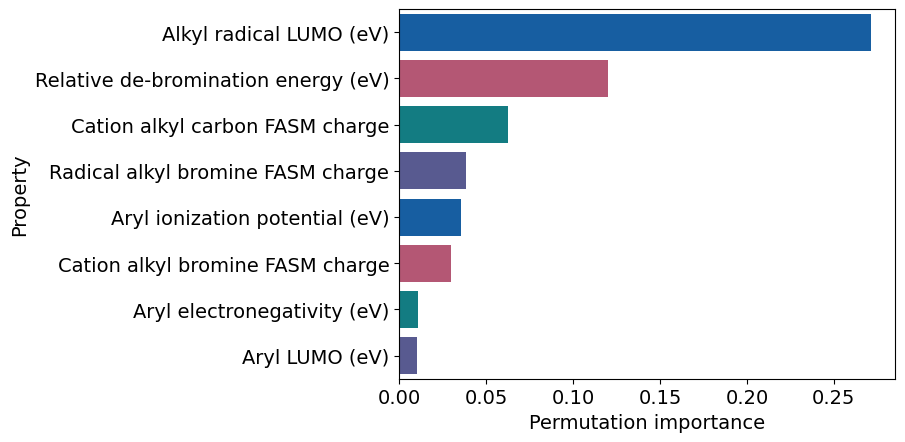

In [9]:
custom_palette = ['#005EB8', '#C4476E', '#008C95', '#4F5199']
sns.barplot(data=df_fasm8, x="importances_mean", y="Property", palette=custom_palette)
plt.xlabel("Permutation importance")
plt.show()

In [60]:
df_exp["f_core_C_tm_water_charge_paboon"].corr(df_exp["f_core_C_tm_water_charge_loewdin"])

0.9297502485988411

In [29]:
print(df_exp[target].corr(df_exp["f_tm_freeh_LUMO(eV)_rad"]))
print(df_exp[target].corr(df_exp["f_rad_br"]))
print(df_exp["f_rad_br"].corr(df_exp["f_tm_freeh_LUMO(eV)_rad"]))

0.4296992206516372
0.31222814153877937
0.27284002484302733


In [31]:
best_feats = ["f_rad_br", "f_tm_freeh_LUMO(eV)_rad"]
model_linreg = sklearn.linear_model.LinearRegression()
model.fit(df_alrand[best_feats], df_alrand[target])
y_pred = model.predict(df_test[best_feats])

{'r2': 0.08254424814812267,
 'mae': 13.673731658061241,
 'rmse': 22.637077763619114,
 'spearmanr': SpearmanrResult(correlation=0.29509342816942447, pvalue=4.505187604987615e-07)}

In [48]:
df_yieldmean = df_exp.groupby("smiles_alkyl")[target].mean()
df_alk = df_exp.copy()
df_alk.drop_duplicates(subset="smiles_alkyl", inplace=True)
df_alk.drop(columns=target, inplace=True)
df_alk = df_alk.merge(df_yieldmean, right_index=True, left_on="smiles_alkyl")
df_alk

,Unnamed: 0,inchikey_short,smiles,smiles_alkyl,smiles_aryl,rsmi,selection,category,inchikey,rsmi_mapped,...,f_Br_tm_water_nucleophilic_fasm,f_Br_tm_water_electrophilic_mulliken,f_Br_tm_water_electrophilic_loewdin,f_Br_tm_water_electrophilic_paboon,f_Br_tm_water_electrophilic_fasm,f_Br_tm_water_radical_mulliken,f_Br_tm_water_radical_loewdin,f_Br_tm_water_radical_paboon,f_Br_tm_water_radical_fasm,CAD Yield (%)
0,240,XNTZQQJYBAVVBN,CC(C)(C)OC(=O)N1CCC(COc2ccc(CCOCCOCCOCCOCCOCCO...,OCCOCCOCCOCCOCCOCCOCCBr,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,OCCOCCOCCOCCOCCOCCOCCBr.CC(C)(C)OC(=O)N1CCC(CO...,active_learning_3,NaN,XNTZQQJYBAVVBN-UHFFFAOYNA-N,[CH3:22][C:23]([CH3:24])([CH3:25])[O:26][C:27]...,...,0.4012,0.0550,0.0457,0.0470,0.0625,0.2240,0.2112,0.1806,0.2319,45.820718
6,320,HDULJUWDQXLZSU,CCCCCCCCCCCCCCCCC(C(=O)O)c1ccc(OCC2CCN(C(=O)OC...,CCCCCCCCCCCCCCCCC(Br)C(=O)O,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,CCCCCCCCCCCCCCCCC(Br)C(=O)O.CC(C)(C)OC(=O)N1CC...,random_4,random_165,HDULJUWDQXLZSU-YLHGWYNBNA-N,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,...,0.3809,0.2060,0.1965,0.2048,0.1867,0.2995,0.2826,0.2665,0.2838,1.670139
14,360,MARBPKJGIONUGQ,Cc1ccc(S(=O)(=O)n2cc(Cc3ccc(OCC4CCN(C(=O)OC(C)...,Cc1ccc(S(=O)(=O)n2cc(CBr)c3ccccc32)cc1,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,Cc1ccc(S(=O)(=O)n2cc(CBr)c3ccccc32)cc1.CC(C)(C...,random_3,random_136,MARBPKJGIONUGQ-UHFFFAOYNA-N,[CH3:1][c:2]1[cH:3][cH:4][c:5]([S:6](=[O:7])(=...,...,0.1035,0.1056,0.0990,0.0997,0.1186,0.1012,0.0965,0.0890,0.1110,6.932742
22,648,JJYNZMHYMLNBSE,COCCOCCOCCOCCOCCOCCc1ccc(OCC2CCN(C(=O)OC(C)(C)...,COCCOCCOCCOCCOCCOCCBr,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,COCCOCCOCCOCCOCCOCCBr.CC(C)(C)OC(=O)N1CCC(COc2...,test_3,test,JJYNZMHYMLNBSE-UHFFFAOYNA-N,[CH3:1][O:2][CH2:3][CH2:4][O:5][CH2:6][CH2:7][...,...,0.4026,0.0515,0.0434,0.0432,0.0680,0.2314,0.2222,0.1794,0.2353,42.139368
30,712,QWPOVVXWQPAMNC,CC(C)(C)OC(=O)N1CCC(COc2ccc(CCCCCCn3c4ccccc4c4...,BrCCCCCCn1c2ccccc2c2ccccc21,CC(C)(C)OC(=O)N1CCC(COc2ccc(Br)cc2)CC1,BrCCCCCCn1c2ccccc2c2ccccc21.CC(C)(C)OC(=O)N1CC...,active_learning_2,NaN,QWPOVVXWQPAMNC-UHFFFAOYNA-N,[CH2:1]([CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][N:...,...,0.0019,0.0025,0.0020,0.0022,0.0038,0.0019,0.0015,0.0018,0.0029,44.073702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,24580,HHTQSEBHRIFCAQ,COCc1cccc(OC)c1CCCCCCC=O,O=CCCCCCCBr,COCc1cccc(OC)c1Br,O=CCCCCCCBr.COCc1cccc(OC)c1Br>>COCc1cccc(OC)c1...,cores2_active_learning_2,NaN,HHTQSEBHRIFCAQ-UHFFFAOYNA-N,NaN,...,0.1761,0.2747,0.2744,0.2836,0.2516,0.2202,0.2195,0.1988,0.2138,25.952034
937,24725,MYXLEAPTROCXDE,C#CCCCCCc1c(COC)cccc1OC,C#CCCCCCBr,COCc1cccc(OC)c1Br,C#CCCCCCBr.COCc1cccc(OC)c1Br>>C#CCCCCCc1c(COC)...,cores2_active_learning_1,NaN,MYXLEAPTROCXDE-UHFFFAOYNA-N,NaN,...,0.3997,0.3354,0.3399,0.3484,0.3085,0.3626,0.3582,0.3268,0.3541,3.352202
938,24772,CRGJSJIYTMNGBE,COCc1cccc(OC)c1CCP(=O)(O)O,O=P(O)(O)CCBr,COCc1cccc(OC)c1Br,O=P(O)(O)CCBr.COCc1cccc(OC)c1Br>>COCc1cccc(OC)...,cores2_active_learning_2,NaN,CRGJSJIYTMNGBE-BAINRFMONA-N,NaN,...,0.4198,0.4119,0.4113,0.4186,0.3773,0.4201,0.4061,0.3762,0.3986,19.757262
941,24958,KQHFHPIGVDYBAV,COCc1cccc(OC)c1C(C)(C)C,CC(C)(C)Br,COCc1cccc(OC)c1Br,CC(C)(C)Br.COCc1cccc(OC)c1Br>>COCc1cccc(OC)c1C...,cores2_active_learning_1,NaN,KQHFHPIGVDYBAV-UHFFFAOYNA-N,NaN,...,0.4219,0.6948,0.6862,0.7211,0.5793,0.5759,0.5456,0.5366,0.5006,0.258773


/tmp/ipykernel_107306/1466558933.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


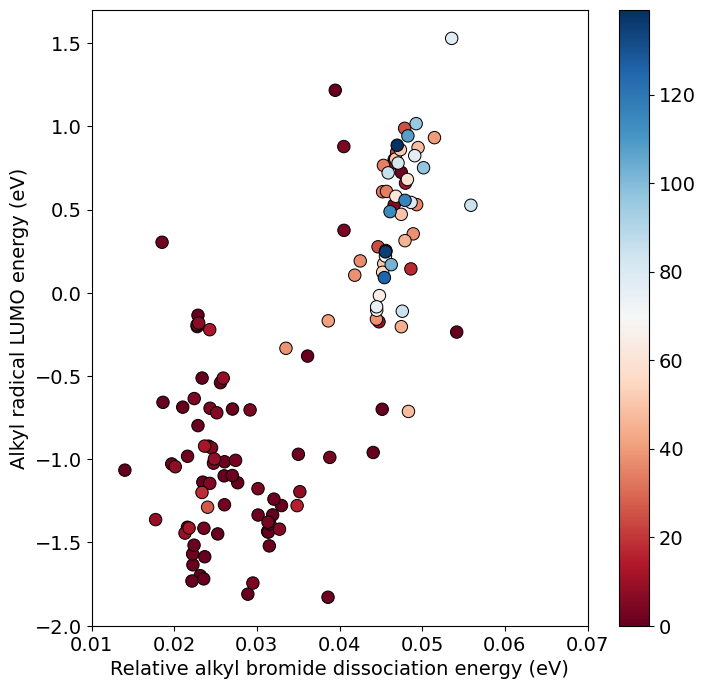

In [58]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_alk.sort_values(by=target), x="f_rad_br", y="f_tm_freeh_LUMO(eV)_rad", hue=target, palette="RdBu", edgecolor="black", s=80)

norm = plt.Normalize(df_exp[target].min(), df_exp[target].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlim([0.01, 0.07])
plt.ylim([-2,1.7])
plt.xlabel("Relative alkyl bromide dissociation energy (eV)")
plt.ylabel("Alkyl radical LUMO energy (eV)")
plt.show()

/tmp/ipykernel_107306/1293718520.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


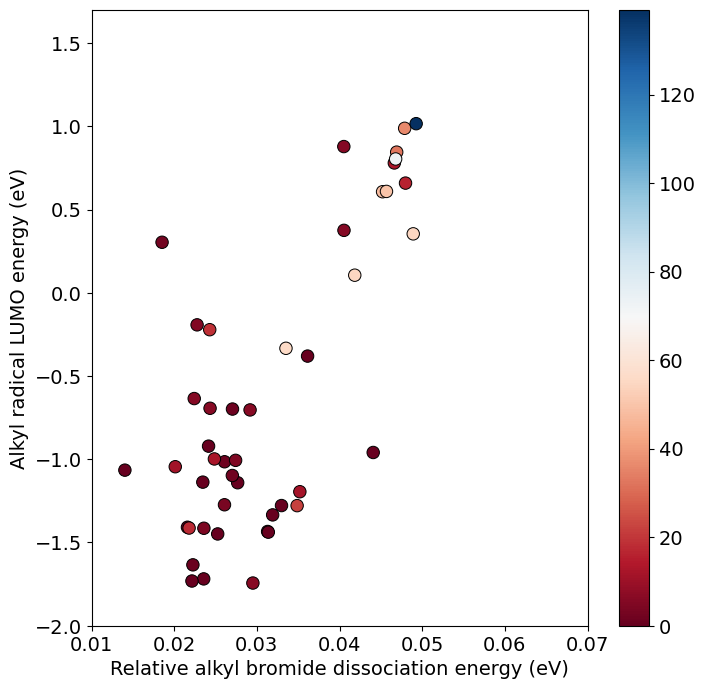

In [56]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_alk[df_alk["selection"].str.contains("random")].sort_values(by=target), x="f_rad_br", y="f_tm_freeh_LUMO(eV)_rad", hue=target, palette="RdBu", edgecolor="black", s=80)

norm = plt.Normalize(df_exp[target].min(), df_exp[target].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlim([0.01, 0.07])
plt.ylim([-2,1.7])
plt.xlabel("Relative alkyl bromide dissociation energy (eV)")
plt.ylabel("Alkyl radical LUMO energy (eV)")
plt.show()